<a href="TAIL"><img src="https://i.imgur.com/GRTE0OG.png" width="150" title="Tail Logo" /></a>

# <font color ="#00b8ff"> Detecção de Fraudes em Cartões de Crédito com Machine Learning </font>

In [ ]:
!pip install haversine

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18ZwGUOJSbsrqTk31pTgKSu2CcR7sZ1U0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18ZwGUOJSbsrqTk31pTgKSu2CcR7sZ1U0" -O credit_card_train.csv && rm -rf /tmp/cookies.txt

--2023-12-10 20:37:47--  https://docs.google.com/uc?export=download&confirm=t&id=18ZwGUOJSbsrqTk31pTgKSu2CcR7sZ1U0
Resolving docs.google.com (docs.google.com)... 74.125.135.101, 74.125.135.100, 74.125.135.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/djaqggr5rpoifgh5oaulhj3ql036kg64/1702240650000/15769217210781797530/*/18ZwGUOJSbsrqTk31pTgKSu2CcR7sZ1U0?e=download&uuid=050bfe2e-1e75-422f-b801-dc2e4d792b87 [following]
--2023-12-10 20:37:48--  https://doc-10-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/djaqggr5rpoifgh5oaulhj3ql036kg64/1702240650000/15769217210781797530/*/18ZwGUOJSbsrqTk31pTgKSu2CcR7sZ1U0?e=download&uuid=050bfe2e-1e75-422f-b801-dc2e4d792b87
Resolving doc-10-0k-docs.googleusercontent.com (doc-10-0k-docs.googleusercontent.com)... 173.194.203.132,

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import plotly.express as px
from datetime import datetime, timedelta
from haversine import haversine_vector, Unit

In [ ]:
dataset = pd.read_csv("credit_card_train.csv")
dataset = dataset.drop(columns=["Unnamed: 0", "cc_num", "trans_num", "unix_time", "zip"])
dataset['dist'] = haversine_vector(dataset[['lat', 'long']].to_numpy(), dataset[['merch_lat', 'merch_long']].to_numpy(), Unit.KILOMETERS)

In [ ]:
dataset['dob'] = pd.to_datetime(dataset['dob'], format='%Y-%m-%d').dt.date
dataset['trans_date_trans_time'] = pd.to_datetime(dataset['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

dataset['date_trans'] = dataset['trans_date_trans_time'].dt.date
dataset['age'] = ((dataset['date_trans'] - dataset['dob']).dt.total_seconds() / (365.25 * 24 * 60 * 60)).astype(int)

dataset[['date_trans', 'time_trans']] = dataset['trans_date_trans_time'].astype(str).str.split(expand=True)
dataset['date_trans'] = dataset['date_trans'].str.slice(stop=7)
dataset['time_trans'] = dataset['time_trans'].str.slice(stop=2)

dataset = dataset.drop(columns=['trans_date_trans_time', 'dob'])

dataset['date_trans'] = pd.to_datetime(dataset['date_trans'])
dataset['month'] = dataset['date_trans'].dt.month

dataset = dataset.assign(is_fraud=dataset.pop('is_fraud'))

In [ ]:
dataset['merchant'] = dataset['merchant'].str.replace('fraud_', '', regex=False)

In [ ]:
dataset

,merchant,category,amt,first,last,gender,street,city,state,lat,...,city_pop,job,merch_lat,merch_long,dist,date_trans,age,time_trans,month,is_fraud
0,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,36.0788,...,3495,"Psychologist, counselling",36.011293,-82.048315,78.597677,2019-01-01,30,00,1,0
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,48.8878,...,149,Special educational needs teacher,49.159047,-118.186462,30.212217,2019-01-01,40,00,1,0
2,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,42.1808,...,4154,Nature conservation officer,43.150704,-112.154481,108.206232,2019-01-01,56,00,1,0
3,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,46.2306,...,1939,Patent attorney,47.034331,-112.561071,95.673363,2019-01-01,51,00,1,0
4,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,38.4207,...,99,Dance movement psychotherapist,38.674999,-78.632459,77.556851,2019-01-01,32,00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,37.7175,...,258,Geoscientist,36.841266,-111.690765,119.752302,2020-06-01,58,12,6,0
1296671,Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,39.2667,...,100,"Production assistant, television",38.906881,-78.246528,75.104189,2020-06-01,40,12,6,0
1296672,Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,32.9396,...,899,Naval architect,33.619513,-105.130529,99.047870,2020-06-01,52,12,6,0
1296673,"Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,43.3526,...,1126,Volunteer coordinator,42.788940,-103.241160,84.627769,2020-06-01,39,12,6,0


## Exploração dos Dados

In [ ]:
transacoes_fraudulentas = dataset[dataset['is_fraud'] == 1]

In [ ]:
data_trans = transacoes_fraudulentas.groupby(['date_trans']).size().reset_index(name='Frequência')

fig = px.line(
    data_trans,
    x='date_trans',
    y='Frequência',
    title='Distribuição do dia das transações',
    labels={'date_trans': 'Data', 'Frequência': 'N° de transações fraudulentas'},
)

fig.update_traces(mode='markers+lines', marker=dict(size=8))

fig.show()

In [ ]:
data_trans = dataset.groupby(['time_trans']).size().reset_index(name='Frequência')

fig = px.line(
    data_trans,
    x='time_trans',
    y='Frequência',
    title='Distribuição do horário das transações',
    labels={'time_trans': 'Hora', 'Frequência': 'N° de transações'},
)

fig.update_traces(mode='markers+lines', marker=dict(size=8))
fig.update_layout(width=800)

fig.show()

In [ ]:
time_trans = transacoes_fraudulentas.groupby(['time_trans']).size().reset_index(name='frequency')

fig = px.line(time_trans, x='time_trans', y='frequency',
             title='Quantidade de Fraudes por Hora',
             labels={'time_trans': 'Hora', 'frequency': 'Frequência'},
             )
fig.update_traces(mode='markers+lines', marker=dict(size=8))
fig.update_layout(width=800)
fig.show()

In [ ]:
from plotly.subplots import make_subplots

In [ ]:
data_trans = dataset.groupby(['time_trans']).size().reset_index(name='Frequência')

fig1 = px.line(
    data_trans,
    x='time_trans',
    y='Frequência',
    title='Distribuição do horário das transações',
    labels={'time_trans': 'Hora', 'Frequência': 'N° de transações'},
)
fig1.update_traces(mode='markers+lines', marker=dict(size=8))
fig1.update_layout(width=400)  # Largura do primeiro gráfico

# Segundo gráfico
time_trans = transacoes_fraudulentas.groupby(['time_trans']).size().reset_index(name='frequency')

fig2 = px.line(
    time_trans,
    x='time_trans',
    y='frequency',
    title='Quantidade de Fraudes por Hora',
    labels={'time_trans': 'Hora', 'frequency': 'Frequência'},
)
fig2.update_traces(mode='markers+lines', marker=dict(size=8))
fig2.update_layout(width=400)  # Largura do segundo gráfico

# Criando subplots lado a lado
fig = make_subplots(rows=1, cols=2, subplot_titles=('Distribuição do horário das transações', 'Quantidade de Fraudes por Hora'))
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)

fig.update_layout(width=1500)

fig.show()

Dá para perceber que no final do dia e na madrugada, há maior ocorrencia de transações fraudulentas, o que pode ser reflexo do perfil de pessoas que tomam a decisão de comprar coisas nesse horário.

In [ ]:
contagem_trans_fraud = transacoes_fraudulentas['merchant'].value_counts().reset_index()
contagem_trans_fraud.columns = ['merchant', 'frequency']

total_fraudes = contagem_trans_fraud['frequency'].sum()

contagem_trans_fraud

,merchant,frequency
0,Rau and Sons,49
1,Cormier LLC,48
2,Kozey-Boehm,48
3,Doyle Ltd,47
4,Vandervort-Funk,47
...,...,...
674,Kuphal-Toy,1
675,Eichmann-Kilback,1
676,Lynch-Mohr,1
677,Tillman LLC,1


In [ ]:
top10_fraudulentas = contagem_trans_fraud.head(10)

fig = px.bar(
    top10_fraudulentas,
    x = 'merchant',
    y = 'frequency',
    title = 'Porcentagem dos locais com maior Frequência de transações fraudulentas',
    labels={'frequency': 'Frequência', 'merchant': 'Estabelecimento'},
    color='frequency',
    text='frequency',
    width=800
)

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

In [ ]:
fraudes_por_idade = transacoes_fraudulentas.groupby('age').size().reset_index(name='qty')

fig = px.bar(fraudes_por_idade, x='age', y='qty',
             title='Quantidade de Fraudes por Idade',
             labels={'age': 'Idade', 'qty': 'Quantidade de Fraudes'},
             color='qty')


fig.show()

## Classifiers

In [ ]:
indexes_to_drop = dataset.sample(n=500000).index

dataset_plot = dataset.drop(indexes_to_drop)
dataset_plot.reset_index(drop=True, inplace=True)

In [ ]:
zeros = dataset[dataset['is_fraud'] == 0].sample(n=7691, random_state=42)
frauds = dataset[dataset['is_fraud'] == 1]

dataset_train = pd.concat([zeros, frauds], axis=0, sort=True).sample(frac=1).reset_index(drop=True)

In [ ]:
dataset_train['is_fraud'].value_counts()

0    7691
1    7506
Name: is_fraud, dtype: int64

In [ ]:
bins = [0, 18, 30, 45, 60, 80, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-80', '81-100']

dataset_train['age_categories'] = pd.cut(dataset_train['age'], bins=bins, labels=labels)

In [ ]:
categorical_columns = ['category', 'gender', 'age_categories']

df = pd.get_dummies(dataset_train[categorical_columns], columns = categorical_columns)

#### Cyclical Encoding

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$
$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

In [ ]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [ ]:
dataset_train = encode(dataset_train,'month', 12)
dataset_plot = encode(dataset_plot,'month', 12)

dataset_train['time_trans'] = dataset_train['time_trans'].astype(int)
dataset_plot['time_trans'] = dataset_plot['time_trans'].astype(int)

dataset_train = encode(dataset_train, 'time_trans', 24)
dataset_plot = encode(dataset_plot, 'time_trans', 24)

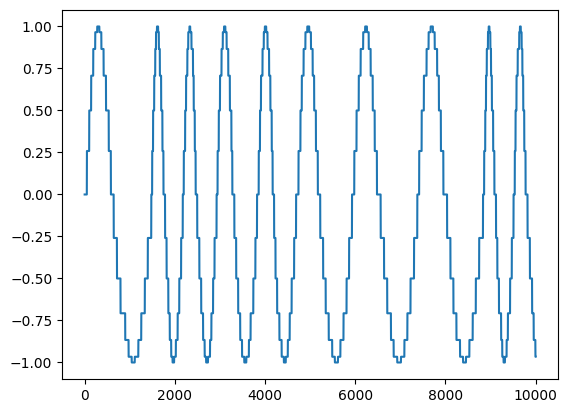

In [ ]:
sample = dataset_plot[0:10000]
ax = sample['time_trans_sin'].plot()

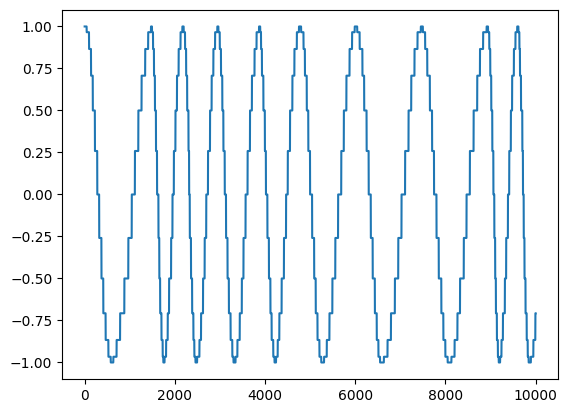

In [ ]:
ax = sample['time_trans_cos'].plot()

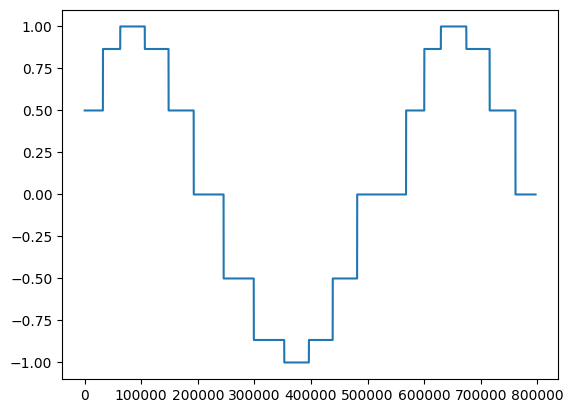

In [ ]:
ax = dataset_plot['month_sin'].plot()

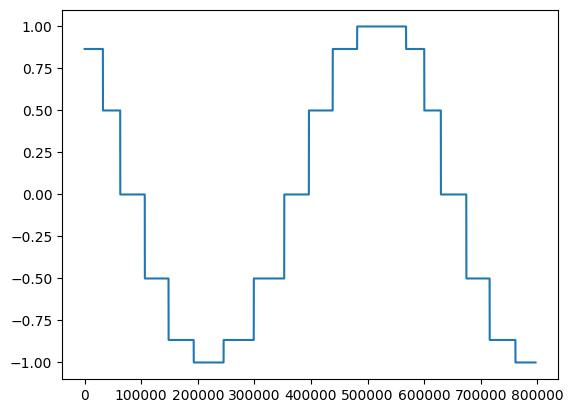

In [ ]:
ax = dataset_plot['month_cos'].plot()

In [ ]:
numerical_columns = ['amt','dist', 'city_pop', 'month_sin', 'month_cos', 'time_trans_cos', 'time_trans_sin']
final_df = pd.concat([df, dataset_train[numerical_columns]], axis=1)

target = dataset_train['is_fraud']

In [ ]:
final_df

,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,...,age_categories_46-60,age_categories_61-80,age_categories_81-100,amt,dist,city_pop,month_sin,month_cos,time_trans_cos,time_trans_sin
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,18.20,88.418785,271,1.000000,6.123234e-17,0.965926,-0.258819
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,6.79,20.874199,964,0.866025,5.000000e-01,1.000000,0.000000
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,37.08,48.308569,69793,-0.500000,-8.660254e-01,0.500000,-0.866025
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,339.86,76.736425,663,0.866025,-5.000000e-01,0.965926,0.258819
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,271.91,61.212410,24840,0.500000,8.660254e-01,0.707107,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15192,0,0,0,0,0,0,0,0,0,1,...,0,0,0,6.78,112.836553,34153,-1.000000,-1.836970e-16,0.965926,-0.258819
15193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,776.70,123.192074,5507,0.500000,8.660254e-01,0.866025,-0.500000
15194,1,0,0,0,0,0,0,0,0,0,...,1,0,0,527.58,86.167101,343,1.000000,6.123234e-17,0.500000,-0.866025
15195,0,0,0,0,0,0,0,0,0,1,...,0,0,0,33.34,78.418702,320420,0.866025,5.000000e-01,0.965926,0.258819


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df, target, test_size = 0.25, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['amt', 'dist', 'city_pop']

x_train_selected = X_train[cols_to_scale]
x_test_selected = X_test[cols_to_scale]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(x_train_selected)
X_test_scaled = scaler.transform(x_test_selected)


In [ ]:
X_train[cols_to_scale] = X_train_scaled

X_test[cols_to_scale] =  X_test_scaled

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 42)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib

In [ ]:
y_pred = classifier.predict(X_test)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

Matriz de Confusão:
[[1828   71]
 [ 487 1414]]
Acurácia: 0.8531578947368421


In [ ]:
joblib.dump(classifier, 'SVC_Classifier_Final.pkl')

['SVC_Classifier_Final.pkl']

## Regressor

In [ ]:
regressor_df = final_df.drop(['amt'], axis=1)
regressor_target = final_df['amt']

In [ ]:
regressor_df

,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,...,age_categories_31-45,age_categories_46-60,age_categories_61-80,age_categories_81-100,dist,city_pop,month_sin,month_cos,time_trans_cos,time_trans_sin
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,88.418785,271,1.000000,6.123234e-17,0.965926,-0.258819
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,20.874199,964,0.866025,5.000000e-01,1.000000,0.000000
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,48.308569,69793,-0.500000,-8.660254e-01,0.500000,-0.866025
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,76.736425,663,0.866025,-5.000000e-01,0.965926,0.258819
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,61.212410,24840,0.500000,8.660254e-01,0.707107,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15192,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,112.836553,34153,-1.000000,-1.836970e-16,0.965926,-0.258819
15193,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,123.192074,5507,0.500000,8.660254e-01,0.866025,-0.500000
15194,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,86.167101,343,1.000000,6.123234e-17,0.500000,-0.866025
15195,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,78.418702,320420,0.866025,5.000000e-01,0.965926,0.258819


In [ ]:
regressor_target

0         18.20
1          6.79
2         37.08
3        339.86
4        271.91
          ...  
15192      6.78
15193    776.70
15194    527.58
15195     33.34
15196     40.26
Name: amt, Length: 15197, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(regressor_df, regressor_target, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['dist', 'city_pop']

x_train_selected = X_train[cols_to_scale]
x_test_selected = X_test[cols_to_scale]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(x_train_selected)
X_test_scaled = scaler.transform(x_test_selected)

In [ ]:
X_train[cols_to_scale] = X_train_scaled

X_test[cols_to_scale] =  X_test_scaled

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor()
regr.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
from sklearn.metrics import r2_score

y_pred = regr.predict(X_test)

r2 = r2_score(y_pred=y_pred, y_true=y_test)

print(r2)

0.5661229279255442


In [ ]:
y_pred

array([298.64,   2.99, 505.19, ..., 340.02,  95.29,  52.34])

##Clusters

### K-Means

In [ ]:
df = dataset[['city_pop', 'amt']]

In [ ]:
scaler = StandardScaler()

scaled_values = scaler.fit_transform(df[['city_pop', 'amt']])
df.loc[:, ['city_pop_T', 'amt_T']] = scaled_values

In [ ]:
df = df[['city_pop_T', 'amt_T']]

In [ ]:
def optimise_k_means(data, max_k):
  means = []
  inertias = []

  for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)

    means.append(k)
    inertias.append(kmeans.inertia_)

  fig = plt.subplots(figsize=(10,5))
  plt.plot(means, inertias, 'o-')
  plt.xlabel('Number os Clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

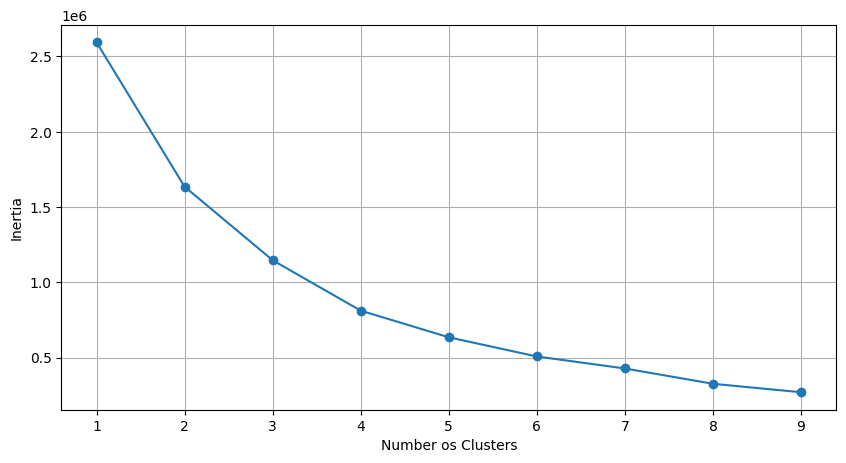

In [ ]:
optimise_k_means(df, 10)

In [ ]:
kmeans = KMeans(n_clusters=4)

dataset_kmeans = dataset.sample(frac=0.01, random_state=42)
kmeans.fit(dataset_kmeans[['city_pop', 'amt']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

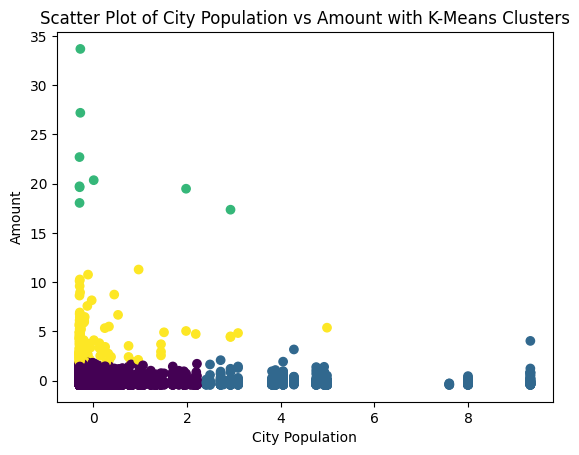

In [ ]:
dataset_kmeans['kmeans_4'] = kmeans.labels_

plt.scatter(x=dataset_kmeans['city_pop'], y=dataset_kmeans['amt'], c=dataset_kmeans['kmeans_4'])
plt.xlabel('City Population')
plt.ylabel('Amount')
plt.title('Scatter Plot of City Population vs Amount with K-Means Clusters')
plt.show()


### Birch

In [ ]:
# Normalizando os dados
dataset_birch = dataset.sample(frac=0.01, random_state=42)
ssc = StandardScaler()
dataset_birch[['amt', 'city_pop']] = ssc.fit_transform(dataset_birch[['amt', 'city_pop']])

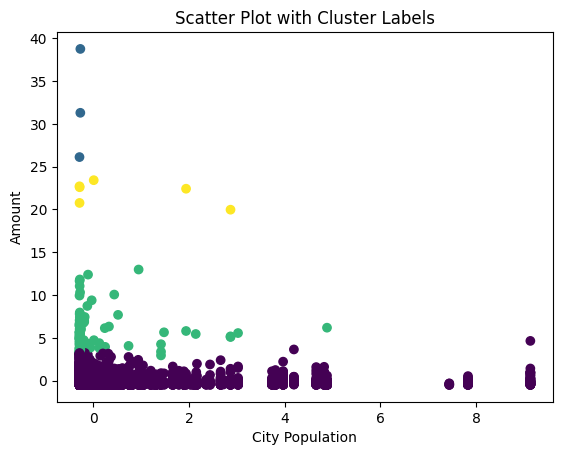

In [ ]:
# Definindo o modelo de clustering
birch = Birch(n_clusters=4)  # Número de clusters definido como 4
# Selecionando os dados relevantes para clustering
X = dataset_birch[['city_pop', 'amt']].values

# Aplicando o algoritmo nos dados normalizados
labels = birch.fit_predict(X)

# Visualizando o resultado
dataset_birch['labels'] = labels

plt.scatter(x=dataset_birch['city_pop'], y=dataset_birch['amt'], c=dataset_birch['labels'])
plt.xlabel('City Population')
plt.ylabel('Amount')
plt.title('Scatter Plot with Cluster Labels')
plt.show()